# 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 재현성 구현

In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
data_path = '/content/drive/MyDrive/data/'
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
df = pd.read_csv(f'{data_path}imdb_dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


- 정답 데이터만들기
  - 긍정: 1
  - 부정: 0

In [5]:
df['sentiment'] = (df['sentiment'] == 'positive').astype(int)
df['sentiment']

,sentiment
0,1
1,1
2,1
3,0
4,1
...,...
49995,1
49996,0
49997,0
49998,0


In [6]:
target = df['sentiment'].to_numpy().reshape(-1,1)
target

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [7]:
target.shape, type(target)

((50000, 1), numpy.ndarray)

# CountVectorizer
- 문서를 단어의 단순 빈도로 벡터화
- 주요 파라미터
  - lowercase: 소문자 변환(default=True)
  - tokenizer: 토큰화 방식> 콜백함수로 전달(default=None)
  - token_pattern: 정규식 이용한 토큰화
  - stop_words: 불용어 제거(default=None)
  - max_df: 빈도수 높은 단어 제거
    - default: 1(100%)

  - min_df: 빈도수 낮은 단어 제거
    - default: 1(100%)
  - max_feature: 전체에서 빈도수 기준, 최대 몇 개의 단어를 구축할지에 대한 개수
    - default: 1(100%)
  - ngram_range: 토큰 묶음단위에 대한 n-gram범위
    - default: (1,1) > Unigram

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
stop_words = list(ENGLISH_STOP_WORDS) # 영어 불용어
# stop_words.append('br')
stop_words.extend(['br','10']) # stop_words에서 'br','10' 제거

- ENGLISH_STOP_WORDS클래스 선언 x
  - CountVectorizer(stop_words='english') > 추가

In [9]:
cnt_vec = CountVectorizer(max_features= 100, stop_words = stop_words) # 최대 피처 개수: 100개, 불용어 제거: ENGLISH_STOP_WORDS
tf_tdm = cnt_vec.fit_transform(df['review']).A # .A: numpy로 변환
tf_tdm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [10]:
tf_tdm.shape

(50000, 100)

In [11]:
tf_tdm = pd.DataFrame(tf_tdm, columns = cnt_vec.get_feature_names_out())
tf_tdm

,acting,action,actors,actually,away,bad,best,better,big,bit,...,want,watch,watching,way,woman,work,world,worst,years,young
0,0,0,0,0,2,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49996,1,0,0,0,0,4,0,2,0,0,...,1,2,0,0,0,0,0,0,0,0
49997,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
from wordcloud import WordCloud # 빈도에 따라 시각화
wc = WordCloud(width= 500, height= 500, random_state=SEED) # default > width=400, height=200, background='color'

- generate_from_frequencies
  - 단어와 그 빈도를 나타내는 딕셔너리를 입력으로 요구  > .sum()
  - 1차원 시리즈나 딕셔너리가 생성

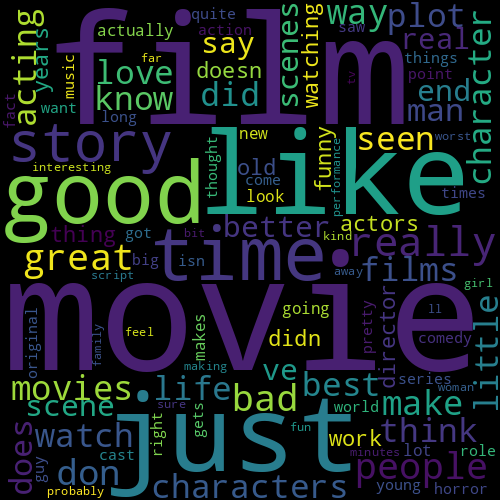

In [13]:
wc_obj = wc.generate_from_frequencies(tf_tdm.sum())
wc_obj.to_image()

# TF-IDF
- 단어 빈도(TF)와 역문서 빈도(DF)를 곱한 값
- 단어 빈도에 가중치 주는 방법
- DF: 문서 빈도
  - 각 단어가 등장한 문서의 개수

- IDF: 역문서 빈도
  - 총 문서 개수를 DF로 나눈 값

- CountVectorizer(단순 빈도)가 더 유용함

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf_vec = TfidfVectorizer(max_features=100, stop_words = stop_words) # 최대 피처 개수: 100개, 불용어 제거: ENGLISH_STOP_WORDS
tfidf_tdm = tfidf_vec.fit_transform(df['review']).A # .A: numpy로 변환
tfidf_tdm # 2차원 형태의 데이터(단어 × 문서)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27261424, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.20434356,
        0.22463457],
       ...,
       [0.20096243, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.19853769, 0.        ,
        0.        ]])

In [16]:
tfidf_tdm.shape

(50000, 100)

In [17]:
tfidf_tdm = pd.DataFrame(tfidf_tdm, columns = tfidf_vec.get_feature_names_out())
tfidf_tdm.head()

,acting,action,actors,actually,away,bad,best,better,big,bit,...,want,watch,watching,way,woman,work,world,worst,years,young
0,0.000000,0.000000,0.000000,0.0,0.362587,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.312702,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.272614,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.268270,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.199503,0.168985,0.24411,0.000000,0.000000,0.0,0.204344,0.224635
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.150056,0.200933,0.000000,0.0,0.000000,0.0,0.156014,0.0,0.187944,0.0,...,0.0,0.148908,0.000000,0.144133,0.00000,0.176151,0.188154,0.0,0.000000,0.000000


- generate_from_frequencies
  - 단어와 그 빈도를 나타내는 딕셔너리를 입력으로 요구 > .sum()
  - 1차원 시리즈나 딕셔너리가 생성

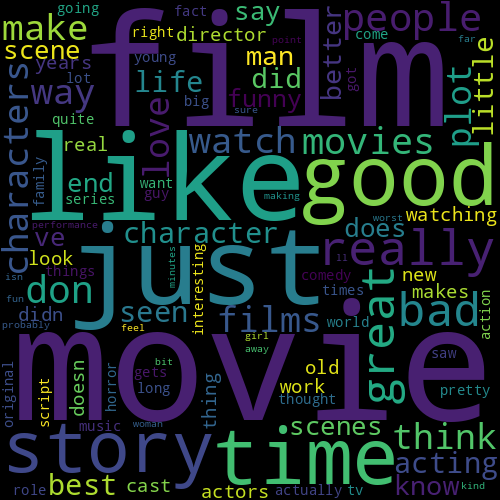

In [18]:
wc = WordCloud(width= 500, height= 500, random_state=SEED)
wc_obj = wc.generate_from_frequencies(tfidf_tdm.sum())
wc_obj.to_image()

# 유사도

## 자카드 유사도
- 교집합의 크기 / 합집합의 크기
- 중복된 단어는 고려하지 않음 > set()

In [19]:
def get_jaccard(text1, text2):
  text1 = set(text1.split())
  text2 = set(text2.split())
  inter_len = len(text1.intersection(text2)) # 교집합 크기
  union_len = len(text1.union(text2)) # 합집합 크기
  return inter_len / union_len

In [20]:
get_jaccard(df['review'][0], df['review'][1])

0.08783783783783784

## 코사인 유사도
- 문서의 유사도 계산 시, 많이 사용
- -1~1 사이의 값
  - 1에 가까울수록 유사도 높음
  - -1에 가까울수록 반대의 의미

In [21]:
from sklearn.metrics .pairwise import cosine_similarity

In [22]:
cosine_similarity(tf_tdm.iloc[:1], tf_tdm.iloc[1:2]) # n개 이상의 벡터화된 데이터 의 상관관계

array([[0.16979054]])

In [23]:
cosine_similarity(tf_tdm.iloc[:5]) # n개 이상의 벡터화된 데이터 의 상관관계

array([[1.        , 0.16979054, 0.20567735, 0.13151919, 0.02450715],
       [0.16979054, 1.        , 0.26919095, 0.20655911, 0.07698004],
       [0.20567735, 0.26919095, 1.        , 0.04170288, 0.21758446],
       [0.13151919, 0.20655911, 0.04170288, 1.        , 0.2981424 ],
       [0.02450715, 0.07698004, 0.21758446, 0.2981424 , 1.        ]])

In [24]:
tf_tdm.shape, tfidf_tdm.shape, target.shape # max_feature= 100

((50000, 100), (50000, 100), (50000, 1))

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
tf_tdm = scaler.fit_transform(tf_tdm)
tf_tdm

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09090909, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14285714,
        0.1       ],
       ...,
       [0.125     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.1       , 0.        ,
        0.        ]])

In [26]:
tfidf_tdm = tfidf_tdm.to_numpy()
tfidf_tdm

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27261424, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.20434356,
        0.22463457],
       ...,
       [0.20096243, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.19853769, 0.        ,
        0.        ]])

# 머신러닝에 학습해보기

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(5, shuffle = True, random_state = SEED)

- TF-TDM데이터 CV점수 확인

In [28]:
model = LogisticRegression(random_state = SEED)
scores = cross_val_score(model, tf_tdm, target, scoring = 'accuracy', cv = cv)
scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.7421599999999999

- TFIDF-TDM데이터 CV점수 확인

In [29]:
model = LogisticRegression(random_state = SEED)
scores = cross_val_score(model, tf_tdm, target, scoring = 'accuracy', cv = cv)
scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.7421599999999999

- TF-TDM, TFIDF-TDM데이터 CV점수 확인

In [30]:
model = LogisticRegression(random_state = SEED)
scores = cross_val_score(model, np.concatenate([tf_tdm, tfidf_tdm], axis = 1), target, scoring = 'accuracy', cv = cv)
scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.7449000000000001